In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from sklearn.linear_model import LogisticRegression 
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix


In [2]:
df_label = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/raw/CMS/UPDATED.csv', low_memory=False)
print(df_label.shape)
print(df_label.head())

(76021, 18)
  LASTNAME FIRSTNAME MIDNAME                      BUSNAME         GENERAL  \
0      NaN       NaN            #1 MARKETING SERVICE, INC  OTHER BUSINESS   
1      NaN       NaN          101 FIRST CARE PHARMACY INC  OTHER BUSINESS   
2      NaN       NaN             14 LAWRENCE AVE PHARMACY        PHARMACY   
3      NaN       NaN             143 MEDICAL EQUIPMENT CO     DME COMPANY   
4      NaN       NaN           184TH STREET PHARMACY CORP  OTHER BUSINESS   

      SPECIALTY UPIN         NPI  DOB                        ADDRESS  \
0    SOBER HOME  NaN           0  NaN      239 BRIGHTON BEACH AVENUE   
1      PHARMACY  NaN  1972902351  NaN  C/O 609 W 191ST STREET, APT D   
2           NaN  NaN           0  NaN             14 LAWRENCE AVENUE   
3  DME - OXYGEN  NaN           0  NaN               701 NW 36 AVENUE   
4      PHARMACY  NaN  1922348218  NaN                  69 E 184TH ST   

        CITY STATE    ZIP EXCLTYPE  EXCLDATE  REINDATE  WAIVERDATE WVRSTATE  
0   BROOKLYN  

In [3]:
print(df_label.info())
print(df_label.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76021 entries, 0 to 76020
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   LASTNAME    72791 non-null  object 
 1   FIRSTNAME   72790 non-null  object 
 2   MIDNAME     76021 non-null  object 
 3   BUSNAME     3228 non-null   object 
 4   GENERAL     76021 non-null  object 
 5   SPECIALTY   71871 non-null  object 
 6   UPIN        6200 non-null   object 
 7   NPI         76021 non-null  int64  
 8   DOB         71930 non-null  float64
 9   ADDRESS     76012 non-null  object 
 10  CITY        76020 non-null  object 
 11  STATE       76016 non-null  object 
 12  ZIP         76021 non-null  int64  
 13  EXCLTYPE    76021 non-null  object 
 14  EXCLDATE    76021 non-null  int64  
 15  REINDATE    76021 non-null  int64  
 16  WAIVERDATE  76021 non-null  int64  
 17  WVRSTATE    11 non-null     object 
dtypes: float64(1), int64(5), object(12)
memory usage: 10.4+ MB
None
  

In [83]:
#get the list of all fraud NPI
df_label_fraud = df_label[df_label['NPI'] != 0]
label = df_label_fraud['NPI'].unique()
print(len(label))

6150


In [90]:
#check if NPI is unique
print(df_label_fraud['NPI'].value_counts())
df_label_fraud[df_label_fraud['NPI'] == 1235282088]

1225072028    3
1801839139    3
1235282088    2
1356339055    2
1801880638    2
             ..
1942389754    1
1770677072    1
1225190606    1
1942495080    1
1174561708    1
Name: NPI, Length: 6150, dtype: int64


,LASTNAME,FIRSTNAME,MIDNAME,BUSNAME,GENERAL,SPECIALTY,UPIN,NPI,DOB,ADDRESS,CITY,STATE,ZIP,EXCLTYPE,EXCLDATE,REINDATE,WAIVERDATE,WVRSTATE
61830,SCHWARTZ,IRVING,JACK,NaN,"PHYSICIAN (MD, DO)",GENERAL PRACTICE,A28402,1235282088,19441117.0,"605 QUEENS AVE, APT 17",YUBA CITY,CA,95991,1128a1,20121018,0,0,NaN
61831,SCHWARTZ,IRVING,JACK,NaN,"PHYSICIAN (MD, DO)",GENERAL PRACTICE,A28402,1235282088,19441117.0,"3901 KLEIN BLVD, #68935-097",LOMPOC,CA,93436,1128a1,20140220,0,0,NaN


In [5]:
#we check the stats of columns again, REINDATE and WAIVERDATE contain no valuable info
print(df_label_fraud.describe())
print(df_label_fraud['WAIVERDATE'].value_counts())

                NPI           DOB           ZIP      EXCLDATE  REINDATE  \
count  6.280000e+03  5.863000e+03   6280.000000  6.280000e+03    6280.0   
mean   1.498480e+09  1.960458e+07  49399.880096  2.015797e+07       0.0   
std    2.882032e+08  1.245219e+05  30372.177613  3.946844e+04       0.0   
min    1.003000e+09  1.921102e+07      0.000000  1.988070e+07       0.0   
25%    1.255305e+09  1.952016e+07  23452.750000  2.013082e+07       0.0   
50%    1.497939e+09  1.960042e+07  44327.000000  2.016062e+07       0.0   
75%    1.740606e+09  1.969122e+07  78212.500000  2.019042e+07       0.0   
max    1.993000e+09  1.994122e+07  99901.000000  2.022072e+07       0.0   

         WAIVERDATE  
count  6.280000e+03  
mean   1.922997e+04  
std    6.218851e+05  
min    0.000000e+00  
25%    0.000000e+00  
50%    0.000000e+00  
75%    0.000000e+00  
max    2.016022e+07  
0           6274
20090618       1
20160218       1
20140917       1
20150618       1
20110720       1
20111115       1
Name: W

In [6]:
#the excldate ranges from 1988 to 2022
print(df_label_fraud['EXCLDATE'].sort_values())
print(df_label_fraud['REINDATE'].value_counts())
#there is no info on REINDATE, so the provider who has been excluded did not get back 

9384     19880703
4847     19881006
7664     19930516
9418     19931022
6382     19931121
           ...   
54559    20220720
11622    20220720
74770    20220720
11239    20220720
63864    20220720
Name: EXCLDATE, Length: 6280, dtype: int64
0    6280
Name: REINDATE, dtype: int64


In [7]:
#We now check the waiverdate, assumption is the excluded provider with waiver can still work in health care programs
print(df_label_fraud[df_label_fraud['WAIVERDATE'] != 0])

         LASTNAME FIRSTNAME         MIDNAME                         BUSNAME  \
3035          NaN       NaN                  UNION COUNTY MEDICAL CENTER IN   
5957        ASWAD   MOHAMED          BASEL                              NaN   
40983       LENTZ     RANDY          SCOTT                              NaN   
47705     MIRANDA   EDUARDO          SIRIA                              NaN   
53405  PATWARDHAN     VINOD  CHANDRASHEKAR                              NaN   
54706     PICKENS      CORY            LEE                              NaN   

                    GENERAL          SPECIALTY    UPIN         NPI  \
3035                 CLINIC                NaN     NaN  1093935355   
5957     PHYSICIAN (MD, DO)           ONCOLOGY  H95172  1871571406   
40983  MEDICAL PRACTICE, MD    FAMILY PRACTICE  H46326  1205832227   
47705    PHYSICIAN (MD, DO)  INTERNAL MEDICINE     NaN  1285673012   
53405  MEDICAL PRACTICE, MD           ONCOLOGY  A87224  1114922606   
54706    PHYSICIAN (MD, DO

In [8]:
#Q: can the waiverdate is before the excldate? 

In [9]:
#import mup_dme, this dataset presents information on DMEPOS products and services provided to Medicare beneficiaries ordered by physicians and other healthcare professionals.  
#description for columns at https://data.cms.gov/resources/medicare-durable-medical-equipment-devices-supplies-by-referring-provider-and-service-data-dictionary
#rfrg = referring
df_mup_dme = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/raw/CMS/mup_dme_ry21_p05_v10_dy19_prvhpr_0.csv', low_memory=False)
print(df_mup_dme.shape)
print(df_mup_dme.columns)
print(df_mup_dme.head())

(1656449, 34)
Index(['Rfrg_NPI', 'Rfrg_Prvdr_Last_Name_Org', 'Rfrg_Prvdr_First_Name',
       'Rfrg_Prvdr_MI', 'Rfrg_Prvdr_Crdntls', 'Rfrg_Prvdr_Gndr',
       'Rfrg_Prvdr_Ent_Cd', 'Rfrg_Prvdr_St1', 'Rfrg_Prvdr_St2',
       'Rfrg_Prvdr_City', 'Rfrg_Prvdr_State_Abrvtn', 'Rfrg_Prvdr_State_FIPS',
       'Rfrg_Prvdr_Zip5', 'Rfrg_Prvdr_RUCA_CAT', 'Rfrg_Prvdr_RUCA',
       'Rfrg_Prvdr_RUCA_Desc', 'Rfrg_Prvdr_Cntry', 'Rfrg_Prvdr_Type_cd',
       'Rfrg_Prvdr_Type', 'Rfrg_Prvdr_Type_Flag', 'BETOS_Lvl', 'BETOS_Cd',
       'BETOS_Desc', 'HCPCS_CD', 'HCPCS_Desc', 'Suplr_Rentl_Ind', 'Tot_Suplrs',
       'Tot_Suplr_Benes', 'Tot_Suplr_Clms', 'Tot_Suplr_Srvcs',
       'Avg_Suplr_Sbmtd_Chrg', 'Avg_Suplr_Mdcr_Alowd_Amt',
       'Avg_Suplr_Mdcr_Pymt_Amt', 'Avg_Suplr_Mdcr_Stdzd_Amt'],
      dtype='object')
     Rfrg_NPI Rfrg_Prvdr_Last_Name_Org Rfrg_Prvdr_First_Name Rfrg_Prvdr_MI  \
0  1003000126                Enkeshafi               Ardalan           NaN   
1  1003000126                Enkeshafi          

In [10]:
#check the stats
print(df_mup_dme.info())
print(df_mup_dme.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656449 entries, 0 to 1656448
Data columns (total 34 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   Rfrg_NPI                  1656449 non-null  int64  
 1   Rfrg_Prvdr_Last_Name_Org  1656449 non-null  object 
 2   Rfrg_Prvdr_First_Name     1656403 non-null  object 
 3   Rfrg_Prvdr_MI             1219478 non-null  object 
 4   Rfrg_Prvdr_Crdntls        1610499 non-null  object 
 5   Rfrg_Prvdr_Gndr           1656403 non-null  object 
 6   Rfrg_Prvdr_Ent_Cd         1656449 non-null  object 
 7   Rfrg_Prvdr_St1            1656449 non-null  object 
 8   Rfrg_Prvdr_St2            576658 non-null   object 
 9   Rfrg_Prvdr_City           1656449 non-null  object 
 10  Rfrg_Prvdr_State_Abrvtn   1656449 non-null  object 
 11  Rfrg_Prvdr_State_FIPS     1656449 non-null  object 
 12  Rfrg_Prvdr_Zip5           1656449 non-null  object 
 13  Rfrg_Prvdr_RUCA_CAT       1

In [11]:
#import data set B
#description for columns at https://data.cms.gov/resources/medicare-durable-medical-equipment-devices-supplies-by-referring-provider-and-service-data-dictionary
#rndrng = rendering

df_B = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/raw/CMS/formB_MUP_PHY_R21_P04_V10_D19_Prov_Svc.csv', encoding = "ISO-8859-1", low_memory=False)
print(df_B.shape)
print(df_B.columns)
print(df_B.head())


(10140228, 29)
Index(['Rndrng_NPI', 'Rndrng_Prvdr_Last_Org_Name', 'Rndrng_Prvdr_First_Name',
       'Rndrng_Prvdr_MI', 'Rndrng_Prvdr_Crdntls', 'Rndrng_Prvdr_Gndr',
       'Rndrng_Prvdr_Ent_Cd', 'Rndrng_Prvdr_St1', 'Rndrng_Prvdr_St2',
       'Rndrng_Prvdr_City', 'Rndrng_Prvdr_State_Abrvtn',
       'Rndrng_Prvdr_State_FIPS', 'Rndrng_Prvdr_Zip5', 'Rndrng_Prvdr_RUCA',
       'Rndrng_Prvdr_RUCA_Desc', 'Rndrng_Prvdr_Cntry', 'Rndrng_Prvdr_Type',
       'Rndrng_Prvdr_Mdcr_Prtcptg_Ind', 'HCPCS_Cd', 'HCPCS_Desc',
       'HCPCS_Drug_Ind', 'Place_Of_Srvc', 'Tot_Benes', 'Tot_Srvcs',
       'Tot_Bene_Day_Srvcs', 'Avg_Sbmtd_Chrg', 'Avg_Mdcr_Alowd_Amt',
       'Avg_Mdcr_Pymt_Amt', 'Avg_Mdcr_Stdzd_Amt'],
      dtype='object')
   Rndrng_NPI Rndrng_Prvdr_Last_Org_Name Rndrng_Prvdr_First_Name  \
0  1003000126                  Enkeshafi                 Ardalan   
1  1003000126                  Enkeshafi                 Ardalan   
2  1003000126                  Enkeshafi                 Ardalan   
3  100300

In [12]:
#check the stats
print(df_B.info())
print(df_B.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10140228 entries, 0 to 10140227
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   Rndrng_NPI                     int64  
 1   Rndrng_Prvdr_Last_Org_Name     object 
 2   Rndrng_Prvdr_First_Name        object 
 3   Rndrng_Prvdr_MI                object 
 4   Rndrng_Prvdr_Crdntls           object 
 5   Rndrng_Prvdr_Gndr              object 
 6   Rndrng_Prvdr_Ent_Cd            object 
 7   Rndrng_Prvdr_St1               object 
 8   Rndrng_Prvdr_St2               object 
 9   Rndrng_Prvdr_City              object 
 10  Rndrng_Prvdr_State_Abrvtn      object 
 11  Rndrng_Prvdr_State_FIPS        float64
 12  Rndrng_Prvdr_Zip5              object 
 13  Rndrng_Prvdr_RUCA              float64
 14  Rndrng_Prvdr_RUCA_Desc         object 
 15  Rndrng_Prvdr_Cntry             object 
 16  Rndrng_Prvdr_Type              object 
 17  Rndrng_Prvdr_Mdcr_Prtcptg_Ind  object 
 18  

In [13]:
#import data set D
#description for D columns at https://data.cms.gov/resources/medicare-part-d-prescribers-by-provider-and-drug-data-dictionary
df_D = pd.read_csv('~/Documents/GitHub/medicare-fraud-detection/data/raw/CMS/formD_MUP_DPR_RY21_P04_V10_DY19_NPIBN_1.csv', encoding = "ISO-8859-1", low_memory=False)
print(df_D.shape)
print(df_D.columns)
print(df_D.head())

(25401870, 22)
Index(['Prscrbr_NPI', 'Prscrbr_Last_Org_Name', 'Prscrbr_First_Name',
       'Prscrbr_City', 'Prscrbr_State_Abrvtn', 'Prscrbr_State_FIPS',
       'Prscrbr_Type', 'Prscrbr_Type_Src', 'Brnd_Name', 'Gnrc_Name',
       'Tot_Clms', 'Tot_30day_Fills', 'Tot_Day_Suply', 'Tot_Drug_Cst',
       'Tot_Benes', 'GE65_Sprsn_Flag', 'GE65_Tot_Clms', 'GE65_Tot_30day_Fills',
       'GE65_Tot_Drug_Cst', 'GE65_Tot_Day_Suply', 'GE65_Bene_Sprsn_Flag',
       'GE65_Tot_Benes'],
      dtype='object')
   Prscrbr_NPI Prscrbr_Last_Org_Name Prscrbr_First_Name Prscrbr_City  \
0   1003000126             Enkeshafi            Ardalan   Cumberland   
1   1003000126             Enkeshafi            Ardalan   Cumberland   
2   1003000126             Enkeshafi            Ardalan   Cumberland   
3   1003000126             Enkeshafi            Ardalan   Cumberland   
4   1003000126             Enkeshafi            Ardalan   Cumberland   

  Prscrbr_State_Abrvtn Prscrbr_State_FIPS       Prscrbr_Type Prscrbr_Typ

In [14]:
#check the stats
print(df_D.info())
print(df_D.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25401870 entries, 0 to 25401869
Data columns (total 22 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Prscrbr_NPI            int64  
 1   Prscrbr_Last_Org_Name  object 
 2   Prscrbr_First_Name     object 
 3   Prscrbr_City           object 
 4   Prscrbr_State_Abrvtn   object 
 5   Prscrbr_State_FIPS     object 
 6   Prscrbr_Type           object 
 7   Prscrbr_Type_Src       object 
 8   Brnd_Name              object 
 9   Gnrc_Name              object 
 10  Tot_Clms               int64  
 11  Tot_30day_Fills        float64
 12  Tot_Day_Suply          int64  
 13  Tot_Drug_Cst           float64
 14  Tot_Benes              float64
 15  GE65_Sprsn_Flag        object 
 16  GE65_Tot_Clms          float64
 17  GE65_Tot_30day_Fills   float64
 18  GE65_Tot_Drug_Cst      float64
 19  GE65_Tot_Day_Suply     float64
 20  GE65_Bene_Sprsn_Flag   object 
 21  GE65_Tot_Benes         float64
dtypes: float64(8), i

In [15]:
#we create a dataframe with first column is NPI and second is PotentialFraud
df_Potential_Fraud = {"NPI":[],"Potential_Fraud":[]}
for i in label:
    df_Potential_Fraud['NPI'].append(i) 
    df_Potential_Fraud['Potential_Fraud'].append('Yes')
df_Potential_Fraud = pd.DataFrame(df_Potential_Fraud)

In [45]:
#join set B with df_Potential_Fraud
df_B = df_B.rename(columns={"Rndrng_NPI": "NPI"})
df_B_fraud = df_B.set_index('NPI').join(df_Potential_Fraud.set_index('NPI'), on = 'NPI', how = 'outer')

In [47]:
print(df_B_fraud['Potential_Fraud'].value_counts())

Yes    7534
Name: Potential_Fraud, dtype: int64


In [51]:
#change Potential_Fraud to float
# df_B_fraud['Potential_Fraud'] = df_B_fraud['Potential_Fraud'].fillna(0)
# for i in df_B_fraud['Potential_Fraud']:
#     if i == 'Yes':
#         df_B_fraud['Potential_Fraud'] = 1
fraud_bool = df_B_fraud['Potential_Fraud'] == 'Yes'
df_B_fraud['Potential_Fraud_bool'] = fraud_bool
df_B_fraud

,NPI,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_MI,Rndrng_Prvdr_Crdntls,Rndrng_Prvdr_Gndr,Rndrng_Prvdr_Ent_Cd,Rndrng_Prvdr_St1,Rndrng_Prvdr_St2,Rndrng_Prvdr_City,...,Place_Of_Srvc,Tot_Benes,Tot_Srvcs,Tot_Bene_Day_Srvcs,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt,Potential_Fraud,Potential_Fraud_bool
1.003000e+09,1003000126,Enkeshafi,Ardalan,NaN,M.D.,M,I,900 Seton Dr,NaN,Cumberland,...,F,40.0,40.0,40.0,232.275000,72.59000,57.870000,58.19175,NaN,False
1.003000e+09,1003000126,Enkeshafi,Ardalan,NaN,M.D.,M,I,900 Seton Dr,NaN,Cumberland,...,F,25.0,25.0,25.0,712.800000,186.72520,148.851600,147.77000,NaN,False
1.003000e+09,1003000126,Enkeshafi,Ardalan,NaN,M.D.,M,I,900 Seton Dr,NaN,Cumberland,...,F,24.0,24.0,24.0,320.166667,101.12125,80.615833,80.81000,NaN,False
1.003000e+09,1003000126,Enkeshafi,Ardalan,NaN,M.D.,M,I,900 Seton Dr,NaN,Cumberland,...,F,157.0,158.0,158.0,651.417722,200.93000,160.190000,161.06000,NaN,False
1.003000e+09,1003000126,Enkeshafi,Ardalan,NaN,M.D.,M,I,900 Seton Dr,NaN,Cumberland,...,F,117.0,205.0,205.0,245.614634,72.75639,58.005561,57.93000,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,1053622035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,True
NaN,1124024435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,True
NaN,1194930149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,True
NaN,1578637385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,True


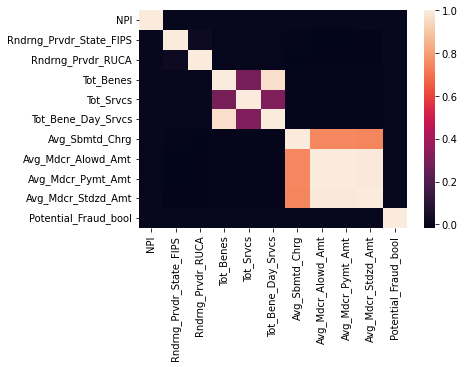

In [54]:
#create heatmap on data B
sns.heatmap(df_B_fraud.corr())
plt.show()

In [144]:
#Tot_Benes and Tot_Bene_Day_srvcs are highly correlated. So we drop. Similar for Avg_Mdcr_alowd, pymt and stdzd
to_drop_B = ['Tot_Bene_Day_Srvcs', 'Avg_Mdcr_Alowd_Amt', 'Avg_Mdcr_Pymt_Amt', 'Avg_Mdcr_Stdzd_Amt', 'Potential_Fraud']
df_B = df_B_fraud.drop(labels = to_drop_B, axis=1)

In [146]:
print(df_B.info())

<class 'pandas.core.frame.DataFrame'>
Float64Index: 10146185 entries, 1003000126.0 to nan
Data columns (total 27 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   NPI                            int64  
 1   Rndrng_Prvdr_Last_Org_Name     object 
 2   Rndrng_Prvdr_First_Name        object 
 3   Rndrng_Prvdr_MI                object 
 4   Rndrng_Prvdr_Crdntls           object 
 5   Rndrng_Prvdr_Gndr              object 
 6   Rndrng_Prvdr_Ent_Cd            object 
 7   Rndrng_Prvdr_St1               object 
 8   Rndrng_Prvdr_St2               object 
 9   Rndrng_Prvdr_City              object 
 10  Rndrng_Prvdr_State_Abrvtn      object 
 11  Rndrng_Prvdr_State_FIPS        float64
 12  Rndrng_Prvdr_Zip5              object 
 13  Rndrng_Prvdr_RUCA              float64
 14  Rndrng_Prvdr_RUCA_Desc         object 
 15  Rndrng_Prvdr_Cntry             object 
 16  Rndrng_Prvdr_Type              object 
 17  Rndrng_Prvdr_Mdcr_Prtcptg_Ind  objec

In [ ]:
#now we group by NPI

In [56]:
#join set D with df_Potential_Fraud
df_D = df_D.rename(columns={"Prscrbr_NPI": "NPI"})
df_D_fraud = df_D.set_index('NPI').join(df_Potential_Fraud.set_index('NPI'), on = 'NPI', how = 'outer')

In [58]:
fraud_bool_D = df_D_fraud['Potential_Fraud'] == 'Yes'
df_D_fraud['Potential_Fraud_bool'] = fraud_bool_D
df_D_fraud

,NPI,Prscrbr_Last_Org_Name,Prscrbr_First_Name,Prscrbr_City,Prscrbr_State_Abrvtn,Prscrbr_State_FIPS,Prscrbr_Type,Prscrbr_Type_Src,Brnd_Name,Gnrc_Name,...,Tot_Benes,GE65_Sprsn_Flag,GE65_Tot_Clms,GE65_Tot_30day_Fills,GE65_Tot_Drug_Cst,GE65_Tot_Day_Suply,GE65_Bene_Sprsn_Flag,GE65_Tot_Benes,Potential_Fraud,Potential_Fraud_bool
1.003000e+09,1003000126,Enkeshafi,Ardalan,Cumberland,MD,24,Internal Medicine,S,Amiodarone Hcl,Amiodarone Hcl,...,NaN,NaN,13.0,13.0,150.76,360.0,*,NaN,NaN,False
1.003000e+09,1003000126,Enkeshafi,Ardalan,Cumberland,MD,24,Internal Medicine,S,Amlodipine Besylate,Amlodipine Besylate,...,12.0,NaN,22.0,26.0,92.81,780.0,NaN,12.0,NaN,False
1.003000e+09,1003000126,Enkeshafi,Ardalan,Cumberland,MD,24,Internal Medicine,S,Atorvastatin Calcium,Atorvastatin Calcium,...,22.0,NaN,41.0,50.0,373.60,1482.0,NaN,22.0,NaN,False
1.003000e+09,1003000126,Enkeshafi,Ardalan,Cumberland,MD,24,Internal Medicine,S,Azithromycin,Azithromycin,...,15.0,#,NaN,NaN,NaN,NaN,#,NaN,NaN,False
1.003000e+09,1003000126,Enkeshafi,Ardalan,Cumberland,MD,24,Internal Medicine,S,Carvedilol,Carvedilol,...,11.0,NaN,21.0,27.0,118.53,787.0,NaN,11.0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
NaN,1053622035,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,True
NaN,1124024435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,True
NaN,1194930149,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,True
NaN,1578637385,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,True


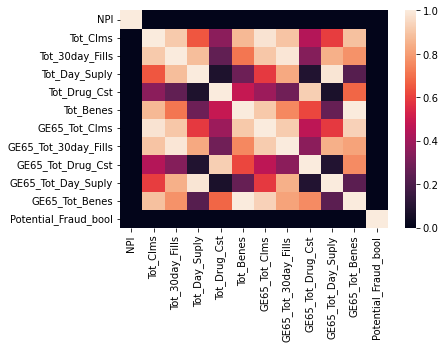

In [59]:
sns.heatmap(df_D_fraud.corr())
plt.show()
#same situation with B

In [157]:
to_drop_D = ['Prscrbr_Last_Org_Name', 'Prscrbr_First_Name', 'Potential_Fraud', 'GE65_Tot_Clms', 'GE65_Tot_30day_Fills', 'GE65_Tot_Drug_Cst', 'GE65_Tot_Day_Suply', 'GE65_Tot_Benes']
df_D = df_D_fraud.drop(labels = to_drop_D, axis=1)

In [158]:
df_D.columns

Index(['NPI', 'Prscrbr_City', 'Prscrbr_State_Abrvtn', 'Prscrbr_State_FIPS',
       'Prscrbr_Type', 'Prscrbr_Type_Src', 'Brnd_Name', 'Gnrc_Name',
       'Tot_Clms', 'Tot_30day_Fills', 'Tot_Day_Suply', 'Tot_Drug_Cst',
       'Tot_Benes', 'GE65_Sprsn_Flag', 'GE65_Bene_Sprsn_Flag',
       'Potential_Fraud_bool'],
      dtype='object')

In [147]:
#join set DME with df_Potential_Fraud
df_mup_dme = df_mup_dme.rename(columns={"Rfrg_NPI": "NPI"})
df_mup_dme_fraud = df_mup_dme.set_index('NPI').join(df_Potential_Fraud.set_index('NPI'), on = 'NPI', how = 'outer')
df_mup_dme_fraud.info()

,NPI,Rfrg_Prvdr_Last_Name_Org,Rfrg_Prvdr_First_Name,Rfrg_Prvdr_MI,Rfrg_Prvdr_Crdntls,Rfrg_Prvdr_Gndr,Rfrg_Prvdr_Ent_Cd,Rfrg_Prvdr_St1,Rfrg_Prvdr_St2,Rfrg_Prvdr_City,...,Suplr_Rentl_Ind,Tot_Suplrs,Tot_Suplr_Benes,Tot_Suplr_Clms,Tot_Suplr_Srvcs,Avg_Suplr_Sbmtd_Chrg,Avg_Suplr_Mdcr_Alowd_Amt,Avg_Suplr_Mdcr_Pymt_Amt,Avg_Suplr_Mdcr_Stdzd_Amt,Potential_Fraud
1.003000e+09,1003000126,Enkeshafi,Ardalan,NaN,M.D.,M,I,900 Seton Dr,NaN,Cumberland,...,Y,5.0,NaN,69.0,69.0,52.207536,22.961739,17.732029,12.496232,NaN
1.003000e+09,1003000126,Enkeshafi,Ardalan,NaN,M.D.,M,I,900 Seton Dr,NaN,Cumberland,...,Y,5.0,12.0,88.0,88.0,362.305227,128.407955,94.287500,52.817273,NaN
1.003001e+09,1003000522,Weigand,Frederick,J,MD,M,I,1565 Saxon Blvd,Suite 102,Deltona,...,N,15.0,22.0,55.0,132.0,61.314242,8.364545,5.757803,5.722652,NaN
1.003001e+09,1003000522,Weigand,Frederick,J,MD,M,I,1565 Saxon Blvd,Suite 102,Deltona,...,N,2.0,NaN,13.0,13.0,14.158462,3.429231,2.686923,2.656154,NaN
1.003001e+09,1003000522,Weigand,Frederick,J,MD,M,I,1565 Saxon Blvd,Suite 102,Deltona,...,N,8.0,13.0,22.0,30.0,13.608667,1.436000,0.979333,0.967333,NaN


In [148]:
df_mup_dme.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656449 entries, 0 to 1656448
Data columns (total 34 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   NPI                       1656449 non-null  int64  
 1   Rfrg_Prvdr_Last_Name_Org  1656449 non-null  object 
 2   Rfrg_Prvdr_First_Name     1656403 non-null  object 
 3   Rfrg_Prvdr_MI             1219478 non-null  object 
 4   Rfrg_Prvdr_Crdntls        1610499 non-null  object 
 5   Rfrg_Prvdr_Gndr           1656403 non-null  object 
 6   Rfrg_Prvdr_Ent_Cd         1656449 non-null  object 
 7   Rfrg_Prvdr_St1            1656449 non-null  object 
 8   Rfrg_Prvdr_St2            576658 non-null   object 
 9   Rfrg_Prvdr_City           1656449 non-null  object 
 10  Rfrg_Prvdr_State_Abrvtn   1656449 non-null  object 
 11  Rfrg_Prvdr_State_FIPS     1656449 non-null  object 
 12  Rfrg_Prvdr_Zip5           1656449 non-null  object 
 13  Rfrg_Prvdr_RUCA_CAT       1

In [69]:
fraud_bool_DME = df_mup_dme_fraud['Potential_Fraud'] == 'Yes'
df_mup_dme_fraud['Potential_Fraud_bool'] = fraud_bool_DME

False    1655699
True        6769
Name: Potential_Fraud_bool, dtype: int64

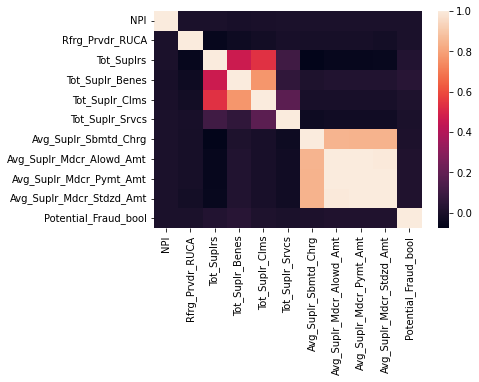

In [70]:
sns.heatmap(df_mup_dme_fraud.corr())
plt.show()

In [159]:
df_mup_dme_fraud.columns

Index(['NPI', 'Rfrg_Prvdr_Last_Name_Org', 'Rfrg_Prvdr_First_Name',
       'Rfrg_Prvdr_MI', 'Rfrg_Prvdr_Crdntls', 'Rfrg_Prvdr_Gndr',
       'Rfrg_Prvdr_Ent_Cd', 'Rfrg_Prvdr_St1', 'Rfrg_Prvdr_St2',
       'Rfrg_Prvdr_City', 'Rfrg_Prvdr_State_Abrvtn', 'Rfrg_Prvdr_State_FIPS',
       'Rfrg_Prvdr_Zip5', 'Rfrg_Prvdr_RUCA_CAT', 'Rfrg_Prvdr_RUCA',
       'Rfrg_Prvdr_RUCA_Desc', 'Rfrg_Prvdr_Cntry', 'Rfrg_Prvdr_Type_cd',
       'Rfrg_Prvdr_Type', 'Rfrg_Prvdr_Type_Flag', 'BETOS_Lvl', 'BETOS_Cd',
       'BETOS_Desc', 'HCPCS_CD', 'HCPCS_Desc', 'Suplr_Rentl_Ind', 'Tot_Suplrs',
       'Tot_Suplr_Benes', 'Tot_Suplr_Clms', 'Tot_Suplr_Srvcs',
       'Avg_Suplr_Sbmtd_Chrg', 'Avg_Suplr_Mdcr_Alowd_Amt',
       'Avg_Suplr_Mdcr_Pymt_Amt', 'Avg_Suplr_Mdcr_Stdzd_Amt',
       'Potential_Fraud'],
      dtype='object')

In [ ]:
#now we consider some of the most important features according to Brendan, including total_claim_count_max, total_30_day_fill_count_std, bene_unique_cnt_mean


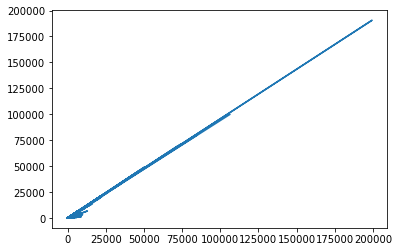

In [39]:
#we work on total claim for set D first
#print(df_D['Tot_Clms'], df_D['GE65_Tot_Clms'])
#rls of totalclaims and total claims for over 65?
plt.plot(df_D['Tot_Clms'], df_D['GE65_Tot_Clms'])
plt.show()

In [79]:
dfD = df_D_fraud.groupby('NPI')['Tot_Clms'].sum().reset_index(name = 'Tot_clm')
dfD = dfD.set_index('NPI').join(df_Potential_Fraud.set_index('NPI'), on = 'NPI', how = 'outer')
fraud_bool_ = dfD['Potential_Fraud'] == 'Yes'
dfD['Potential_Fraud_bool'] = fraud_bool_
dfD

,Tot_clm,Potential_Fraud,Potential_Fraud_bool
NPI,,,
1003000126,336.0,NaN,False
1003000142,972.0,NaN,False
1003000167,43.0,NaN,False
1003000282,12.0,NaN,False
1003000407,0.0,Yes,True
...,...,...,...
1992999650,38.0,NaN,False
1992999759,198.0,Yes,True
1992999825,163.0,NaN,False


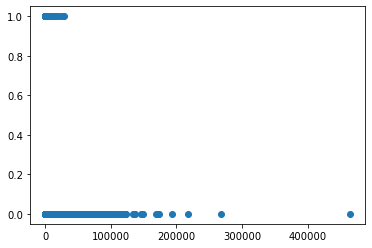

In [81]:
plt.scatter(dfD['Tot_clm'], dfD['Potential_Fraud_bool'])
plt.show()

In [92]:
dat_B_agg = df_B.groupby(['NPI','Rndrng_Prvdr_Ent_Cd', 'Rndrng_Prvdr_Cntry']).agg(
                                                   {'Tot_Srvcs':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                    'Tot_Benes':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                    'Tot_Bene_Day_Srvcs':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                    'Avg_Sbmtd_Chrg':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                    'Avg_Mdcr_Pymt_Amt': ['sum', 'mean', 'median', np.std, 'min', 'max']
                                                 })
dat_B_agg.head()

Tot_Srvcs              \
                                                        sum        mean   
NPI        Rndrng_Prvdr_Ent_Cd Rndrng_Prvdr_Cntry                         
1003000126 I                   US                    1367.0  151.888889   
1003000134 I                   US                    7805.0  650.416667   
1003000142 I                   US                    1095.0   60.833333   
1003000423 I                   US                      86.0   28.666667   
1003000480 I                   US                      83.0   27.666667   

                                                                             \
                                                  median          std   min   
NPI        Rndrng_Prvdr_Ent_Cd Rndrng_Prvdr_Cntry                             
1003000126 I                   US                   40.0   190.250128  24.0   
1003000134 I                   US                  203.0  1601.485246  18.0   
1003000142 I                   US                   45.5    55.320723  11.0   
1003000423 I                   US                   27.0    13.576941  16.0   
1003000480 I                   US                   21.0    13.316656  19.0   

                                                          Tot_Benes  \
                                                      max       sum   
NPI        Rndrng_Prvdr_Ent_Cd Rndrng_Prvdr_Cntry                     
1003000126 I                   US                   605.0       969   
1003000134 I                   US                  5716.0      4773   
1003000142 I                   US                   224.0       709   
1003000423 I                   US                    43.0        82   
1003000480 I                   US                    43.0        73   

                                                                      \
                                                         mean median   
NPI        Rndrng_Prvdr_Ent_Cd Rndrng_Prvdr_Cntry                      
1003000126 I                   US                  107.666667   40.0   
1003000134 I                   US                  397.750000   92.5   
1003000142 I                   US                   39.388889   29.5   
1003000423 I                   US                   27.333333   23.0   
1003000480 I                   US                   24.333333   21.0   

                                                               ...  \
                                                          std  ...   
NPI        Rndrng_Prvdr_Ent_Cd Rndrng_Prvdr_Cntry              ...   
1003000126 I                   US                  106.070731  ...   
1003000134 I                   US                  955.578561  ...   
1003000142 I                   US                   30.076645  ...   
1003000423 I                   US                   14.011900  ...   
1003000480 I                   US                    9.451631  ...   

                                                  Avg_Sbmtd_Chrg              \
                                                          median         std   
NPI        Rndrng_Prvdr_Ent_Cd Rndrng_Prvdr_Cntry                              
1003000126 I                   US                     345.236364  206.458732   
1003000134 I                   US                     137.000000   74.965244   
1003000142 I                   US                     160.636364   94.134306   
1003000423 I                   US                      50.000000   32.145503   
1003000480 I                   US                     203.000000   49.074773   

                                                                        \
                                                       min         max   
NPI        Rndrng_Prvdr_Ent_Cd Rndrng_Prvdr_Cntry                        
1003000126 I                   US                  229.475  712.800000   
1003000134 I                   US                   68.000  350.000000   
1003000142 I                   US                   18.000  365.128205   
1003000423 I            

In [93]:
dat_D_agg = df_D.groupby(['NPI','Prscrbr_Type']).agg(
                                                  {'Tot_Benes':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                   'Tot_Clms':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                   'Tot_30day_Fills':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                   'Tot_Day_Suply':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                   'Tot_Drug_Cst': ['sum', 'mean', 'median', np.std, 'min', 'max']
                                                  })
dat_D_agg.head()

Tot_Benes                               \
                                         sum       mean median        std   
NPI        Prscrbr_Type                                                     
1003000126 Internal Medicine           181.0  15.083333   13.5   5.567084   
1003000142 Anesthesiology              414.0  31.846154   30.0  26.021934   
1003000167 Dentist                      36.0  18.000000   18.0   7.071068   
1003000282 Nurse Practitioner            0.0        NaN    NaN        NaN   
1003000423 Obstetrics & Gynecology      11.0  11.000000   11.0        NaN   

                                                Tot_Clms                    \
                                     min    max      sum       mean median   
NPI        Prscrbr_Type                                                      
1003000126 Internal Medicine        11.0   30.0      336  18.666667   15.0   
1003000142 Anesthesiology           11.0  105.0      972  60.750000   34.5   
1003000167 Dentist                  13.0   23.0       43  21.500000   21.5   
1003000282 Nurse Practitioner        NaN    NaN       12  12.000000   12.0   
1003000423 Obstetrics & Gynecology  11.0   11.0      106  17.666667   17.0   

                                               ... Tot_Day_Suply               \
                                          std  ...        median          std   
NPI        Prscrbr_Type                        ...                              
1003000126 Internal Medicine         8.317239  ...         471.0   393.154849   
1003000142 Anesthesiology           61.505013  ...        1098.5  2013.956401   
1003000167 Dentist                  10.606602  ...         111.0    19.798990   
1003000282 Nurse Practitioner             NaN  ...         420.0          NaN   
1003000423 Obstetrics & Gynecology   6.022181  ...         647.0   564.163717   

                                              Tot_Drug_Cst               \
                                    min   max          sum         mean   
NPI        Prscrbr_Type                                                   
1003000126 Internal Medicine         73  1482      9798.06   544.336667   
1003000142 Anesthesiology           420  8407     44952.80  2809.550000   
1003000167 Dentist                   97   125       169.49    84.745000   
1003000282 Nurse Practitioner       420   420        95.03    95.030000   
1003000423 Obstetrics & Gynecology  164  1582     14671.45  2445.241667   

                                                                            
                                     median          std     min       max  
NPI        Prscrbr_Type                                                     
1003000126 Internal Medicine        150.980  1671.251796   40.25   7234.67  
1003000142 Anesthesiology           833.055  6232.854718   99.18  25818.67  
1003000167 Dentist                   84.745     6.512453   80.14     89.35  
1003000282 Nurse Practitioner        95.030          NaN   95.03     95.03  
1003000423 Obstetrics & Gynecology  619.985  3704.954292  172.77   9592.06  

[5 rows x 30 columns]

In [94]:
dat_dem_agg = df_mup_dme.groupby(['NPI',]).agg({'Tot_Suplrs':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                       'Tot_Suplr_Benes':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                       'Tot_Suplr_Clms':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                       'Tot_Suplr_Srvcs':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                       'Avg_Suplr_Mdcr_Pymt_Amt':['sum', 'mean', 'median', np.std, 'min', 'max'],
                                                       'Avg_Suplr_Mdcr_Stdzd_Amt': ['sum', 'mean', 'median', np.std, 'min', 'max']
                                                 })
                                                                                    
dat_dem_agg.head()

Tot_Suplrs                                    Tot_Suplr_Benes  \
                  sum      mean median       std min max             sum   
NPI                                                                        
1003000126         10  5.000000    5.0  0.000000   5   5            12.0   
1003000522         27  6.750000    5.0  6.184658   2  15            35.0   
1003000530         25  4.166667    3.0  3.188521   1   9             0.0   
1003000902         61  5.545455    3.0  5.047051   2  17            33.0   
1003001363          5  1.666667    2.0  0.577350   1   2            54.0   

                                   ... Avg_Suplr_Mdcr_Pymt_Amt              \
            mean median       std  ...                  median         std   
NPI                                ...                                       
1003000126  12.0   12.0       NaN  ...               56.009764   54.132893   
1003000522  17.5   17.5  6.363961  ...                4.222363   26.057561   
1003000530   NaN    NaN       NaN  ...                3.469125   12.138938   
1003000902  16.5   16.5  7.778175  ...                5.182857   18.252060   
1003001363  18.0   14.0  7.810250  ...              779.950000  439.747788   

                                  Avg_Suplr_Mdcr_Stdzd_Amt              \
                  min         max                      sum        mean   
NPI                                                                      
1003000126  17.732029   94.287500                65.313505   32.656752   
1003000522   0.979333   55.106250                62.746139   15.686535   
1003000530   0.039196   32.054545                46.111569    7.685262   
1003000902   0.034488   61.243636               108.697483    9.881589   
1003001363  96.190000  917.119630              1789.069630  596.356543   

                                                           
                median         std        min         max  
NPI                                                        
1003000126   32.656752   28.511281  12.496232   52.817273  
1003000522    4.189403   25.219240   0.967333   53.400000  
1003000530    3.469125   12.134086   0.039196   32.036364  
1003000902    4.401913   15.775359   0.034488   51.998182  
1003001363  793.380000  441.286803  90.880000  904.809630  

[5 rows x 36 columns]

In [96]:
merged_d = dat_dem_agg.reset_index().merge(dat_D_agg, how='inner', left_on=['NPI'], right_on=['NPI'])
merged_d = merged_d.merge(dat_B_agg, how='inner', left_on='NPI', right_on='NPI')

In [114]:
df_label_fraud = df_label[df_label['NPI'] != 0]
df_label_fraud = df_label_fraud.set_index('NPI')
print(df_label_fraud.shape)
print(df_label.shape)

(6280, 17)
(76021, 18)


In [115]:
df_label_fraud = df_label_fraud[~df_label_fraud.index.duplicated(keep='first')].reset_index('NPI')
pd.Series(df_label_fraud.NPI).is_unique

True

In [117]:
print(df_label_fraud.shape)

(6150, 18)


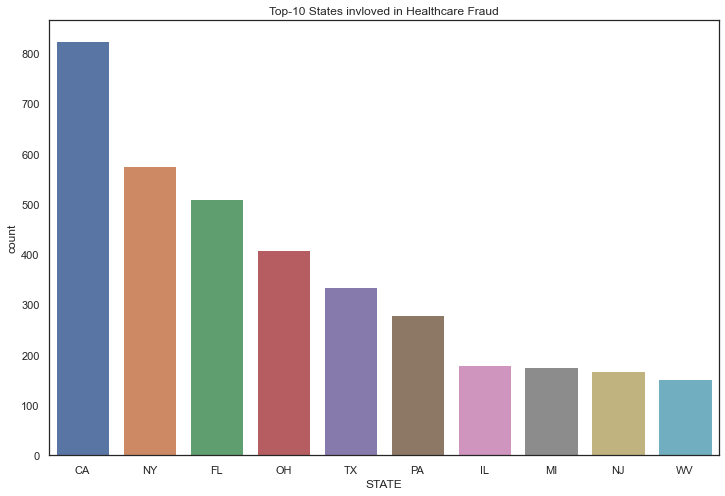

In [119]:
sns.set(rc={'figure.figsize':(12,8)},style='white')

ax=sns.countplot(x='STATE',data=df_label_fraud
              ,order=df_label_fraud.STATE.value_counts().iloc[:10].index)

plt.title('Top-10 States invloved in Healthcare Fraud')
    
plt.show()


MIAMI, FL          78
BROOKLYN, NY       76
LOS ANGELES, CA    58
MORGANTOWN, WV     53
LAS VEGAS, NV      52
                   ..
HONESDALE, PA       1
PALM COAST, FL      1
LITTLE ROCK, AR     1
BRIGHTON, CO        1
HEWLETT, NY         1
Name: city, Length: 2656, dtype: int64


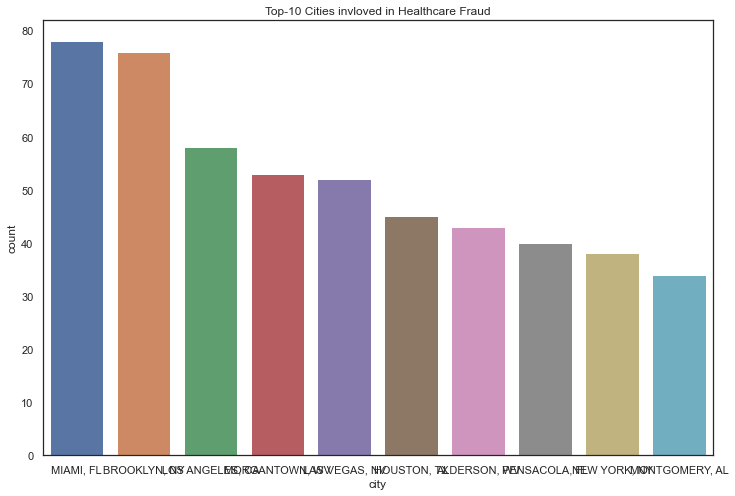

In [135]:

df_label_fraud['city'] = df_label_fraud['CITY'] + ', ' + df_label_fraud['STATE']
print(df_label_fraud.city.value_counts())
#sns.set(rc={'figure.figsize':(12,8)},style='white')
ax=sns.countplot(x='city',data=df_label_fraud
             ,order=df_label_fraud.city.value_counts().iloc[:10].index)

plt.title('Top-10 Cities invloved in Healthcare Fraud')
    
plt.show()

In [123]:
df_label_fraud[df_label_fraud['CITY'] == 'MIAMI']

,NPI,LASTNAME,FIRSTNAME,MIDNAME,BUSNAME,GENERAL,SPECIALTY,UPIN,DOB,ADDRESS,CITY,STATE,ZIP,EXCLTYPE,EXCLDATE,REINDATE,WAIVERDATE,WVRSTATE
17,1447560867,NaN,NaN,,"ALBERT ADES, M D, P A",PHYSICIAN PRACTICE (,GENERAL PRACTICE,NaN,NaN,"P O BOX 779800, #67194-050",MIAMI,FL,33177,1128b8,20170620,0,0,NaN
31,1215968847,NaN,NaN,,AMERICAN THERAPEUTIC CORP,OTHER BUSINESS,CLINIC,NaN,NaN,1801 NE 2ND AVENUE,MIAMI,FL,33132,1128b7,20160115,0,0,NaN
129,1174806004,NaN,NaN,,"ERRI, INC",OTHER BUSINESS,PHARMACY,NaN,NaN,"C/O 900 BISCAYNE BLVD, APT 530",MIAMI,FL,33132,1128a1,20220320,0,0,NaN
261,1215034582,NaN,NaN,,ON SITE THERAPY AND EDUCATION,OTHER BUSINESS,PHYS THERAPY PROVIDE,NaN,NaN,7310 SW 169TH STREET,MIAMI,FL,33457,1128a1,20141218,0,0,NaN
311,1487039392,NaN,NaN,,REHABILITATION CENTER AT HOLLY,OTHER BUSINESS,SKILLED NURSING FAC,NaN,NaN,12605 BISCAYNE BAY DRIVE,MIAMI,FL,33181,1128b5,20181120,0,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5991,1467618066,WILLIAMSON,RYAN,,NaN,BUS OWNER/EXEC,DME - GENERAL,NaN,19680909.0,"P O BOX 779800, #69291-018",MIAMI,FL,33177,1128a1,20190418,0,0,NaN
5997,1831115674,WILLNER,MARK,,NaN,"PHYSICIAN (MD, DO)",PSYCHIATRY,NaN,19551005.0,"P O BOX 019120, #96366-004",MIAMI,FL,33101,1128a1,20130418,0,0,NaN
6114,1205923216,ZAGER,MARK,ALAN,NaN,"PHYSICIAN (MD, DO)",FAMILY PRACTICE,NaN,19490512.0,"P O BOX 1027, #64398-509",MIAMI,FL,33521,1128a1,20220720,0,0,NaN
6141,1760602551,ZIGMOND,BORIS,,NaN,IND- LIC HC SERV PRO,CHIROPRACTIC,NaN,19660105.0,"PO BOX 779800, #07790-104",MIAMI,FL,33177,1128a4,20190718,0,0,NaN


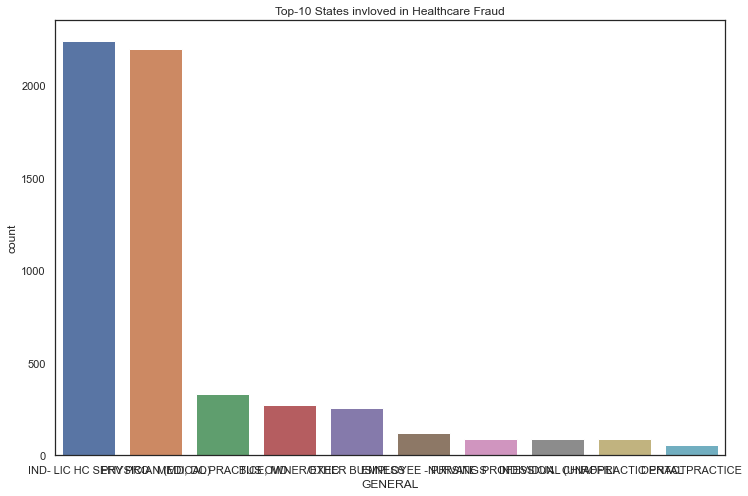

IND- LIC HC SERV PRO    2239
PHYSICIAN (MD, DO)      2198
MEDICAL PRACTICE, MD     333
BUS OWNER/EXEC           274
OTHER BUSINESS           258
EMPLOYEE - PRIVATE S     118
NURSING PROFESSION        87
INDIVIDUAL (UNAFFILI      87
CHIROPRACTIC PRACT        86
DENTAL PRACTICE           55
PHYSICIAN PRACTICE (      54
DME COMPANY               50
PHARMACY                  37
COUNSELING CENTER         33
PRIVATE CIT/ENTITY        33
OSTEOPATHIC PRAC          32
CLINIC                    26
PSYCHOLOGIC PRACTICE      25
PODIATRY PRACTICE         21
PHYSICIAN ASSISTANT       19
PHYSICAL THERAPIST        10
TRANSPORTATION CO          9
THERAPIST                  9
ACUPUNCTURIST              9
AMBULANCE COMPANY          9
HOME HEALTH AGENCY         8
LABORATORY                 4
EMPLOYEE - HHS             3
RURAL HEALTH CLINIC        3
HOSPITAL                   2
OWNER/EXEC-GOVT CONT       2
OPTICAL PRACTICE           2
STATE/LOCAL/TRIBAL A       2
OPTOMETRIC PRACTICE        2
ADULT HOME    

In [137]:
sns.set(rc={'figure.figsize':(12,8)},style='white')

ax=sns.countplot(x='GENERAL',data=df_label_fraud
              ,order=df_label_fraud.GENERAL.value_counts().iloc[:10].index)

plt.title('Top-10 States invloved in Healthcare Fraud')
    
plt.show()

print(df_label_fraud.GENERAL.value_counts())

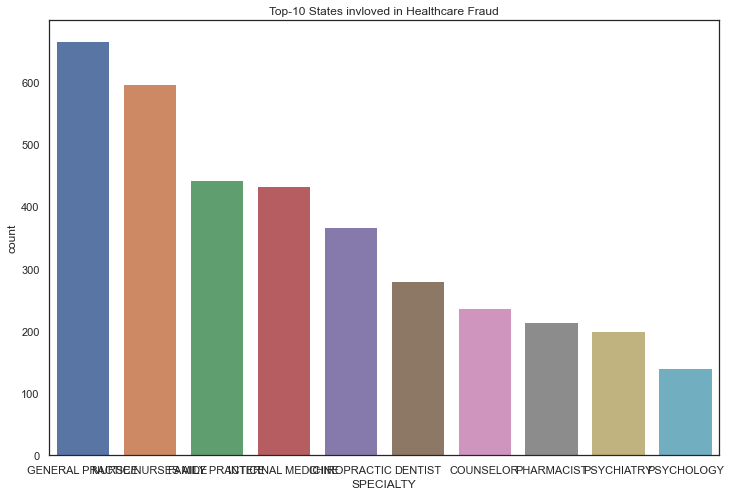

GENERAL PRACTICE        666
NURSE/NURSES AIDE       597
FAMILY PRACTICE         443
INTERNAL MEDICINE       433
CHIROPRACTIC            367
                       ... 
HOTEL/LODGING             1
REPRESENTATIVE PAYEE      1
PROCTOLOGY                1
DME - HOME INFUSION       1
ALLIED HEALTH RELATE      1
Name: SPECIALTY, Length: 121, dtype: int64


In [138]:
sns.set(rc={'figure.figsize':(12,8)},style='white')

ax=sns.countplot(x='SPECIALTY',data=df_label_fraud
              ,order=df_label_fraud.SPECIALTY.value_counts().iloc[:10].index)

plt.title('Top-10 States invloved in Healthcare Fraud')
    
plt.show()

print(df_label_fraud.SPECIALTY.value_counts())